# 0.0. Imports

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns
import warnings
import datetime as dt
import umap.umap_ as umap
import random     as rd
import re

from matplotlib import pyplot as plt

from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn import cluster as c
from sklearn import metrics
from sklearn import ensemble as en
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy as hc

from plotly import express as px

## 0.2. Load dataset

In [2]:
!cd

C:\Users\rauul\repos\insiders_clustering\notebooks


In [3]:
# load data
df_raw = pd.read_csv( r'..\data\raw\Ecommerce.csv', encoding= 'unicode_escape')

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )

# <font color='black'> 1.0. Descrição dos dados </font>

In [4]:
df1 = df_raw.copy()

## 1.1. Rename columuns

In [5]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
             'unit_price', 'customer_id', 'country']

In [6]:
df1.columns = cols_new

## 1.2. Data dimensions

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of cols: 8


## 1.3. Data types

In [8]:
df1.head(3)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,29-Nov-16,2.75,17850.0,United Kingdom


In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity        float64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isnull().sum()

invoice_no           0
stock_code        6035
description       7489
quantity          6035
invoice_date      6035
unit_price        6035
customer_id     138727
country           6035
dtype: int64

## 1.5. Replace NA

In [11]:
df1 = df1[~df1['stock_code'].isna()]

In [12]:
df1.isnull().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     132692
country              0
dtype: int64

In [13]:
df_missing = df1.loc[df1['customer_id'].isna(),:]
df_not_missing = df1.loc[~df1['customer_id'].isna(),:]

In [14]:
# check customer id, if invoice_no in missing dataset into invoices not missing dataset
missing_invoice = df_missing['invoice_no'].drop_duplicates().to_list()
df_not_missing.loc[df_not_missing['invoice_no'].isin(missing_invoice),'customer_id']

Series([], Name: customer_id, dtype: float64)

In [15]:
# create refence to use missing values
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000,19000+len(df_backup),1)

# merge original with reference datafram
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x','customer_id_y'], axis=1)

df1.head(3)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6.0,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,29-Nov-16,2.75,United Kingdom,17850.0


In [16]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

In [17]:
# remove na
#df1 = df1.dropna(subset=['description','customer_id'])
#print('Removed data: {:.2f}'.format(1-(df1.shape[0]/df_raw.shape[0])))

In [18]:
df_missing.tail(30)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
541511,581498,71053,WHITE MOROCCAN METAL LANTERN,1.0,7-Dec-17,8.29,NaN,United Kingdom
541512,581498,72349b,SET/6 PURPLE BUTTERFLY T-LIGHTS,2.0,7-Dec-17,4.13,NaN,United Kingdom
541513,581498,79321,CHILLI LIGHTS,10.0,7-Dec-17,12.46,NaN,United Kingdom
541514,581498,82001s,SILVER RECORD COVER FRAME,2.0,7-Dec-17,7.46,NaN,United Kingdom
541515,581498,82482,WOODEN PICTURE FRAME WHITE FINISH,4.0,7-Dec-17,4.96,NaN,United Kingdom
541516,581498,82552,WASHROOM METAL SIGN,1.0,7-Dec-17,2.46,NaN,United Kingdom
541517,581498,82580,BATHROOM METAL SIGN,1.0,7-Dec-17,1.25,NaN,United Kingdom
541518,581498,82581,TOILET METAL SIGN,1.0,7-Dec-17,1.25,NaN,United Kingdom
541519,581498,82600,N0 SINGING METAL SIGN,4.0,7-Dec-17,4.13,NaN,United Kingdom
541520,581498,84029E,RED WOOLLY HOTTIE WHITE HEART.,4.0,7-Dec-17,8.29,NaN,United Kingdom


## 1.6. Change dtypes

In [19]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity        float64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [20]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y') #format é o formato origiral que está no dataset, para sim a função realizar a formatação

# customer_id
df1['customer_id'] = df1['customer_id'].astype('int64')

In [21]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6.0,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2016-11-29,3.39,United Kingdom,17850


## 1.7. Descriptive Statistics

In [22]:
num_att = df1.select_dtypes(include=['float64','int64'])
cat_att = df1.select_dtypes(exclude=['float64','int64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [23]:
# central tedency
ct1 = pd.DataFrame(num_att.apply(np.mean)).T
ct2 = pd.DataFrame(num_att.apply(np.mean)).T

# dispersion metrics
d1 = pd.DataFrame(num_att.apply(np.std)).T
d2 = pd.DataFrame(num_att.apply(np.min)).T
d3 = pd.DataFrame(num_att.apply(np.max)).T
d4 = pd.DataFrame(num_att.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_att.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).T

# concat
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-74215.00,74215.0,148430.00,9.587927,9.587927,153.292079,-0.488860,205255.513778
1,unit_price,-11062.06,38970.0,50032.06,4.636533,4.636533,97.302142,185.470194,58350.655856
2,customer_id,12346.00,22696.0,10350.00,16679.693656,16679.693656,2907.335598,0.490492,-0.798387


### 1.7.2. Categorical Attributes

In [24]:
cat_att.head(3)

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom


### 1.7.2.1 Invoice Number

In [25]:
#invoice number
invoice_inv = cat_att.loc[cat_att['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+',x)))]
print('Number of invoice with letters in code: {}'.format(len(invoice_inv['invoice_no'].unique())))

Number of invoice with letters in code: 3821


In [26]:
# registros com quantidade negativa, tem letras no código dos invoices
print('Invoices with letter in code: {}'.format(len(invoice_inv)))
print('Rows with negative quantity: {}'.format(len(df1.loc[df1['quantity'] <0])))

Invoices with letter in code: 9224
Rows with negative quantity: 10545


### 1.7.2.2 Stock Code

In [27]:
# stock code 1
stock_inv = cat_att.loc[cat_att['stock_code'].apply(lambda x: bool(re.search('[^0-9]+',x))), 'stock_code'].drop_duplicates()
print('Number of stock codes with letters in code: {}'.format(len(stock_inv)))

Number of stock codes with letters in code: 1070


In [28]:
# stock code 2
stock_inv2 = cat_att.loc[cat_att['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$',x))), 'stock_code'].drop_duplicates()
print('Number of stock codes string: {}'.format(len(stock_inv2)))

Number of stock codes string: 12


In [29]:
stock_inv2 = stock_inv2.to_list()
print('Stock Codes to remove: {}'.format(stock_inv2))

Stock Codes to remove: ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']


In [30]:
#view table with code
df1.loc[df1['stock_code'] == 'CRUK']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
313348,C564763,CRUK,CRUK Commission,-1.0,2017-08-28,1.60,United Kingdom,14096
319774,C565382,CRUK,CRUK Commission,-1.0,2017-08-31,13.01,United Kingdom,14096
329433,C566216,CRUK,CRUK Commission,-1.0,2017-09-07,15.96,United Kingdom,14096
334453,C566565,CRUK,CRUK Commission,-1.0,2017-09-11,52.24,United Kingdom,14096
346535,C567655,CRUK,CRUK Commission,-1.0,2017-09-19,608.66,United Kingdom,14096
357024,C568345,CRUK,CRUK Commission,-1.0,2017-09-24,447.56,United Kingdom,14096
368085,C569245,CRUK,CRUK Commission,-1.0,2017-10-01,361.59,United Kingdom,14096
385168,C570487,CRUK,CRUK Commission,-1.0,2017-10-08,411.92,United Kingdom,14096
396840,C571440,CRUK,CRUK Commission,-1.0,2017-10-15,495.98,United Kingdom,14096
411421,C572551,CRUK,CRUK Commission,-1.0,2017-10-22,425.14,United Kingdom,14096


### 1.7.2.3 Description

In [31]:
# remove column

### 1.7.2.4 Country

In [32]:
# Rows by country
df1['country'].value_counts(normalize=True)

United Kingdom          0.913873
Germany                 0.017631
France                  0.015909
EIRE                    0.015186
Spain                   0.004690
Netherlands             0.004395
Belgium                 0.003844
Switzerland             0.003715
Portugal                0.002825
Australia               0.002335
Norway                  0.002014
Italy                   0.001480
Channel Islands         0.001405
Finland                 0.001282
Cyprus                  0.001148
Sweden                  0.000857
Unspecified             0.000829
Austria                 0.000745
Denmark                 0.000718
Japan                   0.000653
Poland                  0.000634
Israel                  0.000549
USA                     0.000543
Hong Kong               0.000532
Singapore               0.000425
Iceland                 0.000338
Canada                  0.000274
Greece                  0.000271
Malta                   0.000235
United Arab Emirates    0.000125
European C

In [33]:
# users by country
df1[['country',
     'customer_id']].drop_duplicates().groupby('country').count().sort_values('customer_id',
                                                                              ascending=False).reset_index().head(10)

,country,customer_id
0,United Kingdom,7572
1,Germany,95
2,France,90
3,EIRE,44
4,Spain,31
5,Belgium,25
6,Switzerland,24
7,Portugal,20
8,Italy,15
9,Hong Kong,15


# <font color='black'> 2.0. Filtragem de Varivéis </font>

In [34]:
df2 = df1.copy()

In [35]:
# == filtering categorical attributes ==
# stock code
df2 = df2[~df2['stock_code'].isin(stock_inv2)]

# description
df2 = df2.drop(columns='description', axis=1)

# country
df2 = df2[~df2['country'].isin(['European Community','Unspecified'])]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# split by quantity positive and negative
df_returns = df2.loc[df2['quantity'] < 0, :]
df_purchase = df2.loc[df2['quantity'] >= 0.04, :]


df2 = df2.loc[df2['unit_price'] >= 0.04, :]

print(df_returns.shape)
print(df_purchase.shape)

(9987, 7)
(522624, 7)


# <font color='black'> 3.0. Feature Engineering </font>

In [36]:
df3 = df2.copy()

## 3.1. Feature Creation

Criação das variáveis base, em relação ao modelo RFM utilizado com Benchmark para o projeto.

In [37]:
# data reference - tabela para chaves primarias

df_ref = df3.drop(['invoice_no','stock_code','quantity',
                   'invoice_date','unit_price','country'], axis=1).drop_duplicates()

df_ref.shape

(5783, 1)

### 3.1.1. Gross Revenue

In [38]:
#gross revenue - quantity * price (faturamento)
df_purchase.loc[:,'gross_revenue'] = df_purchase.loc[:,'quantity'] * df_purchase.loc[:,'unit_price']

#Monetary
df_monetary = df_purchase[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
print(df_ref.shape)
df_ref.isnull().sum()

(5783, 2)


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Day from last purchase

In [39]:
#recency - last date invoice by customer - today
df_recency = df_purchase.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
print(df_ref.shape)
df_ref.isna().sum()

(5783, 3)


customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.8. Quantity of products purchased

In [40]:
# number of products purchase
df_freq = (df_purchase.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count().reset_index().rename( columns={'stock_code': 'qt_products'}))
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
print(df_ref.shape)
df_ref.isna().sum()

(5783, 4)


customer_id       0
gross_revenue    91
recency_days     91
qt_products      91
dtype: int64

### 3.1.9. Frequency Purchase

In [41]:
df_purchase.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id,gross_revenue
0,536365,85123A,6.0,2016-11-29,2.55,United Kingdom,17850,15.30
1,536365,71053,6.0,2016-11-29,3.39,United Kingdom,17850,20.34
2,536365,84406B,8.0,2016-11-29,2.75,United Kingdom,17850,22.00
3,536365,84029G,6.0,2016-11-29,3.39,United Kingdom,17850,20.34
4,536365,84029E,6.0,2016-11-29,3.39,United Kingdom,17850,20.34


In [42]:
df_aux = (df_purchase[['invoice_no',
                       'customer_id',
                       'invoice_date']].drop_duplicates().groupby('customer_id').agg(max_ = ('invoice_date','max'),
                                                                                    min_ = ('invoice_date','min'),
                                                                                    days_= ('invoice_date', lambda x: (x.max() - x.min()).days),
                                                                                    buy_ = ('invoice_no','count'))).reset_index()

# frequency
df_aux['frequency'] = df_aux[['buy_','days_']].apply(lambda x: x['buy_']/ x['days_'] if x['days_'] != 0 else 0, axis=1)

# merge

df_ref = pd.merge(df_ref, df_aux[['customer_id','frequency']], on='customer_id', how='left')
print(df_ref.shape)
df_ref.isna().sum()

(5783, 5)


customer_id       0
gross_revenue    91
recency_days     91
qt_products      91
frequency        91
dtype: int64

### 3.1.6. Number of returns

In [43]:
#returns
df_returns1 = df_returns[['customer_id','quantity']].drop_duplicates().groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtd_returns'})
df_returns1.loc[:,'qtd_returns'] = df_returns1.loc[:,'qtd_returns'] * -1

df_ref = pd.merge(df_ref, df_returns1, how='left', on='customer_id')
df_ref.loc[df_ref['qtd_returns'].isna(), 'qtd_returns'] = 0
print(df_ref.shape)
df_ref.isna().sum()

(5783, 6)


customer_id       0
gross_revenue    91
recency_days     91
qt_products      91
frequency        91
qtd_returns       0
dtype: int64

# <font color='black'> 4.0. EDA ( Exploratory Data Analysis ) </font>

In [44]:
df4 = df_ref.dropna().copy()

# <font color='black'> 5.0. Data Preparation </font>

In [45]:
df5 = df4.copy()

In [46]:
df5.shape

(5692, 6)

In [47]:
mm = pp.MinMaxScaler()

df5['gross_revenue'] = mm.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = mm.fit_transform(df5[['recency_days']])
df5['qt_products'] = mm.fit_transform(df5[['qt_products']])
df5['frequency'] = mm.fit_transform(df5[['frequency']])
df5['qtd_returns'] = mm.fit_transform(df5[['qtd_returns']])

In [48]:
df5.head(3)

,customer_id,gross_revenue,recency_days,qt_products,frequency,qtd_returns
0,17850,0.019411,0.997319,0.038218,1.000000,0.000283
1,13047,0.011301,0.150134,0.021175,0.000835,0.000081
2,12583,0.024143,0.005362,0.029826,0.001189,0.000674


# <font color='black'> 6.0. Feature Selection </font>

Qual o sentido de selecionar apenas as colunas abaixo?
1. Quando formos criar o perfil dos clusters, precisamos identificar um valor média de uma variável, neste caso, não faz sentido eu calcular o valor médio de uma variável de um cluster, se essa variável já é uma média
2. Em casos de variáveis muito relacionadas, verificar qual tem um maior ganho de informção ou identificar com o time de negócio, qual seria melhor para eles explicarem o agrupamento.

In [49]:
df6 = df5.copy()
df6.head()

,customer_id,gross_revenue,recency_days,qt_products,frequency,qtd_returns
0,17850,0.019411,0.997319,0.038218,1.000000,0.000283
1,13047,0.011301,0.150134,0.021175,0.000835,0.000081
2,12583,0.024143,0.005362,0.029826,0.001189,0.000674
3,13748,0.003413,0.254692,0.003486,0.000529,0.000000
4,15100,0.003153,0.892761,0.000258,0.002206,0.000296


In [50]:
cols_select = ['customer_id','gross_revenue','recency_days','qt_products','frequency','qtd_returns']

In [51]:
df6 = df6[cols_select].copy()

In [52]:
df6.head()

,customer_id,gross_revenue,recency_days,qt_products,frequency,qtd_returns
0,17850,0.019411,0.997319,0.038218,1.000000,0.000283
1,13047,0.011301,0.150134,0.021175,0.000835,0.000081
2,12583,0.024143,0.005362,0.029826,0.001189,0.000674
3,13748,0.003413,0.254692,0.003486,0.000529,0.000000
4,15100,0.003153,0.892761,0.000258,0.002206,0.000296


# 7.0. Hyperparameter Fine-Tunning

In [53]:
df7 = df6.copy()

## 7.1. Criando espaços de dados

In [54]:
X = df7.copy()

### 7.1.1. PCA

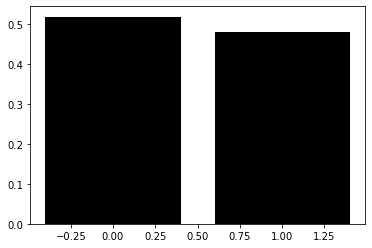

In [77]:
pca = dd.PCA(n_components=X.shape[1] )

principal_components = pca.fit_transform(X)

# plot explained varibles
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black');

# pca component
df_pca = pd.DataFrame(principal_components)

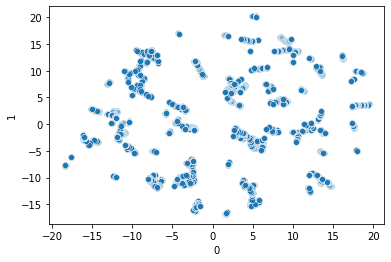

In [78]:
sns.scatterplot(x=0, y=1, data=df_pca);

### 7.1.2. UMAP

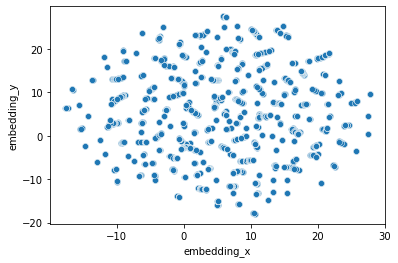

In [79]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X) #embedding, espaço projetado. Saindo do min para o max, ou ao contrário. 2D to 9D or 9D to 2D

#embedding

df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                data=df_pca);

### 7.1.3. t-SNE

C:\Users\rauul\anaconda3\envs\insiders\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\rauul\anaconda3\envs\insiders\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


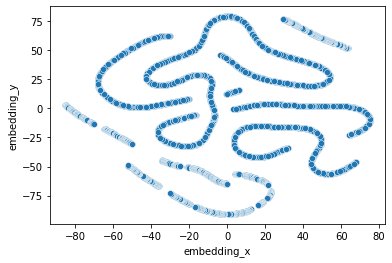

In [61]:
reducer = TSNE(n_components=2, random_state=42, n_jobs=-1)
embedding = reducer.fit_transform(X) #embedding, espaço projetado. Saindo do min para o max, ou ao contrário. 2D to 9D or 9D to 2D

#embedding

df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                data=df_pca);

### 7.1.1. Final Model - Embedding

In [62]:
#training dataset
x = df7.drop(columns=['customer_id','gross_revenue'], axis=1)
y = df7['gross_revenue']

In [74]:
# final model
#model definition
rf_model = en.RandomForestRegressor(n_estimators=250, random_state=42)

#model training
rf_model.fit(x,y)

#dataframe leafs
df_leaf = pd.DataFrame(rf_model.apply(x))

C:\Users\rauul\anaconda3\envs\insiders\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


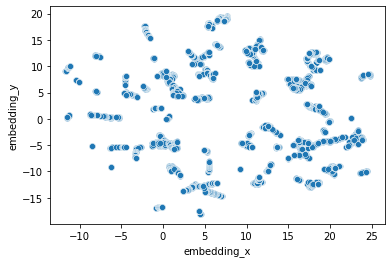

In [75]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf) #embedding, espaço projetado. Saindo do min para o max, ou ao contrário. 2D to 9D or 9D to 2D

#embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                data=df_tree);

## 7.2. Fine Tuning Model Clustering

In [95]:
X = df_tree.copy()

In [96]:
X.head(3)

,embedding_x,embedding_y
0,21.475883,-3.526814
1,16.831593,-4.407052
2,18.616110,-4.532408


# <font color='black'> 8.0. Model Training </font>

In [97]:
k=8
# Model definition
gmm_model = GaussianMixture(n_components=k, max_iter=300, random_state=42)
# Model Training 
gmm_model.fit(X)
# Model Predict
labels = gmm_model.predict(X)

### 8.2. Cluster Validation

In [98]:
# WSS
#print('WSS value: {}'.format(gmm_model.inertia_))

# SS
print('SS value: {}'.format(metrics.silhouette_score(X, labels, metric='euclidean')))

SS value: 0.36822813749313354


# <font color='black'> 9.0. Cluster Analysis </font>

In [106]:
df9 = df4.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,qt_products,frequency,qtd_returns,cluster
0,17850,5391.21,372.0,297.0,34.000000,21.0,5
1,13047,3138.99,56.0,165.0,0.028391,6.0,5
2,12583,6705.38,2.0,232.0,0.040431,50.0,5
3,13748,948.25,95.0,28.0,0.017986,0.0,6
4,15100,876.00,333.0,3.0,0.075000,22.0,2


## <font color='black'> 9.1. Visualization Inspection </font>

In [107]:
df_viz = X.copy()
df_viz['cluster'] = labels

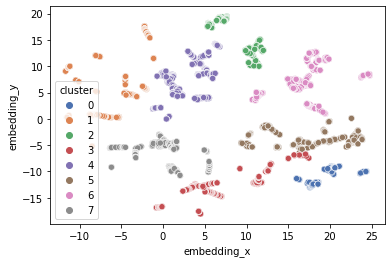

In [108]:
sns.scatterplot(x='embedding_x',y='embedding_y',hue='cluster',data=df_viz, palette='deep');

## 9.2. Cluster Profile

In [109]:
df9.head(3)

,customer_id,gross_revenue,recency_days,qt_products,frequency,qtd_returns,cluster
0,17850,5391.21,372.0,297.0,34.000000,21.0,5
1,13047,3138.99,56.0,165.0,0.028391,6.0,5
2,12583,6705.38,2.0,232.0,0.040431,50.0,5


In [110]:
#Number of customer
df9_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df9_cluster['percentage'] = 100*(df9_cluster['customer_id'] / df9_cluster['customer_id'].sum())

#Avg Gross Revenue
df_avg_revenue = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df9_cluster = pd.merge(df9_cluster, df_avg_revenue, how='inner', on='cluster')

#Avg Recency Days
df_avg_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df9_cluster = pd.merge(df9_cluster, df_avg_days, how='inner', on='cluster')

#Avg Frequency
df_avg_freq = df9[['frequency','cluster']].groupby('cluster').mean().reset_index()
df9_cluster = pd.merge(df9_cluster, df_avg_freq, how='inner', on='cluster')

#Qtd Products
df_avg_product = df9[['qt_products','cluster']].groupby('cluster').mean().reset_index()
df9_cluster = pd.merge(df9_cluster, df_avg_product, how='inner', on='cluster')

#Qtd Returns
df_avg_returns = df9[['qtd_returns','cluster']].groupby('cluster').mean().reset_index()
df9_cluster = pd.merge(df9_cluster, df_avg_returns, how='inner', on='cluster')

In [111]:
df9_cluster.sort_values('gross_revenue', ascending=False)

,cluster,customer_id,percentage,gross_revenue,recency_days,frequency,qt_products,qtd_returns
5,5,1045,18.359100,5698.175569,47.825837,0.087540,288.696651,132.669856
0,0,382,6.711174,1561.250497,118.178010,0.009904,93.816754,3.581152
6,6,1047,18.394238,1273.694117,78.829035,0.033401,75.554919,5.452722
1,1,586,10.295151,1154.115358,176.273038,0.002474,32.656997,2.948805
3,3,574,10.084329,1123.645662,117.515679,0.008406,77.324042,12.245645
2,2,583,10.242446,699.661441,120.720412,0.059227,25.147513,4.012007
4,4,923,16.215741,378.728202,156.425785,0.000452,25.832069,0.693391
7,7,552,9.697822,134.285290,185.244565,0.000035,5.192029,0.639493


### Clusters Name

- 5. Insiders
- 0. Expectation
- 6. Cheapers
- 1. Hope
- 3. Cheap
- 2. Less1k
- 4. Quitters
- 7. Forgotten

### Cluster 01:  ( Candidato à Insider )
    - Número de customers: 1045 (18% do customers )
    - Recência em média: 47 dias
    - Compras em média: 288 compras
    - GMV: $5.698,17 dólares
       